In [24]:
import torch
from glob import glob
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from IPython.core.display import display, HTML
from sklearn.manifold import TSNE

In [6]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.style.use('dark_background')

display(HTML("<style>"
    + "#notebook { padding-top:0px; } " ""
    + ".container { width:100%; } "
    + ".end_space { min-height:0px; } "
    + "</style>"))

In [7]:
def print_exp_info(exp: dict):
    print(f'model: {exp["model"]} {exp["approach"]}')
    print({k: exp[k] for k in exp if k not in ['logs', 'results', 'knowledge']})

# usage example:  show_exp_images(experiments[0], True)
def show_exp_images(exp: dict, show_origins=False):
    for task in exp['results']:
        cur_images = exp['results'][task]['images']
        fig, axs = plt.subplots(2, 5, figsize=(15, 8))
        fig.suptitle(f'TASK {task} {exp["knowledge"][task]}', fontsize=30)
        for r, row in enumerate(axs):
            for c, cell in enumerate(row):
                idx = r*5 + c
                image = np.zeros((28, 28, 3), dtype=float)
                cell.set_title(cur_images[idx]['label'])
                orig = np.array(cur_images[idx]['original'][0])
                recon = np.array(cur_images[idx]['reconstruction'][0]).clip(0, 1)
                if show_origins:
                    image[:,:,1] = orig
                image[:,:,0] = recon
                image[:,:,2] = recon
                cell.imshow(image)
        plt.show()

In [161]:
def calc_D_L_torch(data: torch.Tensor, sigma=1.):
    dist_matrix = ((data[None, ...] - data.unsqueeze(1)) ** 2).sum(-1)
    # compute affinity matrix
    A = torch.exp(-dist_matrix / (sigma ** 2))

    # compute degree matrix
    D = torch.diag(A.sum(1))
    # compute laplacian
    L = D - A
    return A, D, L

def find_eig_torch(laplacian: torch.Tensor, return_sorted_indices=False):
    eigenvalues, eigenvectors = torch.linalg.eig(laplacian)
    eigenvalues = eigenvalues.to(float)
    eigenvectors = eigenvectors.to(float)
    sorted_indices = torch.argsort(eigenvalues)
    eigenvalues, eigenvectors = eigenvalues[sorted_indices], eigenvectors[:, sorted_indices]
#     print(eigenvalues,'\n'*2 ,eigenvectors)
    if return_sorted_indices:
        return eigenvalues, eigenvectors, sorted_indices
    else:
        return eigenvalues, eigenvectors

def normalize_A_torch(a_m, d_m):
    return torch.sqrt(torch.linalg.inv(d_m))@a_m@torch.sqrt(torch.linalg.inv(d_m))

def dir_energy(data: torch.Tensor, sigma=1):
    A, D, L = calc_D_L_torch(data, sigma=sigma)
    eigenvalues, eigenvectors = find_eig_torch(L)
    energy = calc_energy_from_values(eigenvalues)
    return energy

def calc_energy_from_values(values: torch.Tensor):
    nsamples = len(values)
    max_value = nsamples * (nsamples - 1)
    dir_energy = values.sum()
    energy_p = dir_energy / max_value
    return energy_p.cpu().item()

def dir_energy_normal(data: torch.Tensor):
    A, D, L = calc_D_L_torch(data)
    L_norm = torch.eye(A.shape[0]).to('cuda')-normalize_A_torch(A, D)
    eigenvalues, eigenvectors = find_eig_torch(L_norm)
    nsamples = len(data)
    max_value = nsamples - 1
    dir_energy = eigenvalues.sum()
    energy_p = dir_energy / max_value
    return energy_p.cpu().item()

def flatten_list(l: List[List[any]]) -> List[any]:
    return [item for line in l for item in line]

In [156]:
logs_path = 'C:\\Users\\emace\\AImageLab\\SRV-Continual\\results\\canomaly\\logs'
logs_path = '../storage/logs'

In [164]:
exp_dict = {}
environments = []
for log_file in glob(logs_path + '/**rec**/*.pyd', recursive=True):
    print(log_file)
    with open(log_file, 'r') as f:
        props_list = [prop.split('-', 1) for prop in log_file.replace(logs_path, '').split('\\')[1:-1]]
        props = {prop[0]: prop[1] for prop in props_list}
        exps = []
        for i, line in enumerate(f.readlines()):
            try:
                exps.append(literal_eval(line.replace('nan', 'None')))
            except:
                print(f'Unparsed line {i}:\n\t{exps[:-1]}\n-->\t{line}')

        environments.append({'env': props, 'exps': exps})

        exps = {exp['id']: exp for exp in exps}
        exp_dict = {**exp_dict, **exps}

../storage/logs/dataset-rec-fmnist/logs.pyd


In [165]:
exp_list = environments[0]['exps']

In [174]:
def show_exp_energies(exp: dict):
    print_exp_info(exp)
    sigma = 1 if exp['model'] == 'rec-vae' else 10
    for task_id in exp['results']:
        task_idx = int(task_id)
        task = exp['results'][task_id]
        targets = torch.tensor(task['targets'], device='cuda')
        latents = torch.tensor(task['latents'], device='cuda')
        knowledge = [k for k in exp['knowledge'].values()]
        for i in range(1, len(knowledge)):
            knowledge[i] = [k for k in knowledge[i] if k not in flatten_list(knowledge[:i])]

        cur_latents = latents[np.isin(targets.cpu(), knowledge[task_idx])]
        past_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]
        fut_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[task_idx:]))]

        print(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})\n'
              f'current:        energy {dir_energy(cur_latents, sigma):.4f}     \tmean {cur_latents.mean():.3f} ± {cur_latents.std():.3f}\n'
              f'with past:      energy {dir_energy(past_latents, sigma):.4f}    \tmean {past_latents.mean():.3f} ± {past_latents.std():.3f}\n'
              f'with future:    energy {dir_energy(fut_latents, sigma):.4f}     \tmean {fut_latents.mean():.3f} ± {fut_latents.std():.3f}\n'
              f'total:          energy {dir_energy(latents, sigma):.4f}         \tmean {latents.mean():.3f} ± {latents.std():.3f}')

In [175]:
for exp in environments[0]['exps'][1:]:
    show_exp_energies(exp)
    print('\n-------------------------\n')

model: rec-vae joint
{'seed': 958621640, 'wandb': False, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'sgd', 'lr': 0.1, 'scheduler_steps': 0, 'scheduler_gamma': 0.1, 'approach': 'joint', 'batch_size': 64, 'n_epochs': 10, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'per_task': False, 'id': '3d7a07be-1198-4d45-957a-ebd3a5929fab', 'timestamp': '2022-03-08 14:04:34.183862'}
0. Task 0 ([0, 2, 3, 4, 6, 1, 5, 7, 9, 8])
current:        energy 0.8487     	mean -0.000 ± 0.052
with past:      energy 0.8487    	mean -0.000 ± 0.052
with future:    energy 0.8487     	mean -0.000 ± 0.052
total:          energy 0.8487         	mean -0.000 ± 0.052

-------------------------

model: rec-vae joint
{'seed': 3267298804, 'wandb': False, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'sgd', 'lr': 0.1, 'scheduler_steps': 0, 'scheduler_gamma': 0.1, 'approach': 'joint', 'batch_siz

model: rec-vae joint
{'seed': 4177323036, 'wandb': False, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'sgd', 'lr': 0.1, 'scheduler_steps': 0, 'scheduler_gamma': 0.1, 'approach': 'joint', 'batch_size': 64, 'n_epochs': 10, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'per_task': True, 'id': '23e82354-b48d-4e6b-b2de-2612745c7f5d', 'timestamp': '2022-03-08 17:13:58.589392'}
369.1732482910156 22.058998107910156 175.79345703125 402.22528076171875
489.1971435546875 21.50112533569336 368.95697021484375 526.0848388671875
742.1806030273438 27.720449447631836 614.7547607421875 799.0029907226562
855.7893676757812 27.754175186157227 724.3213500976562 904.4598388671875


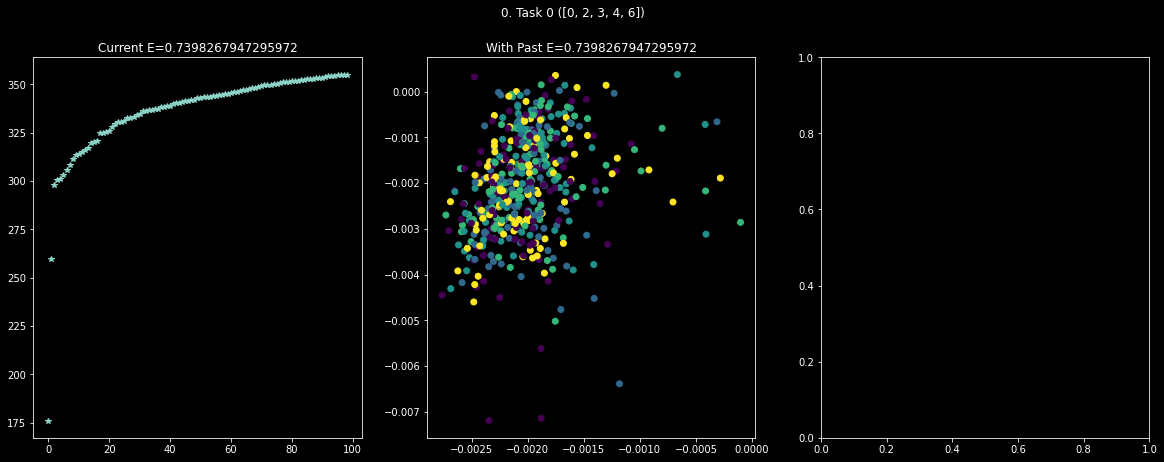

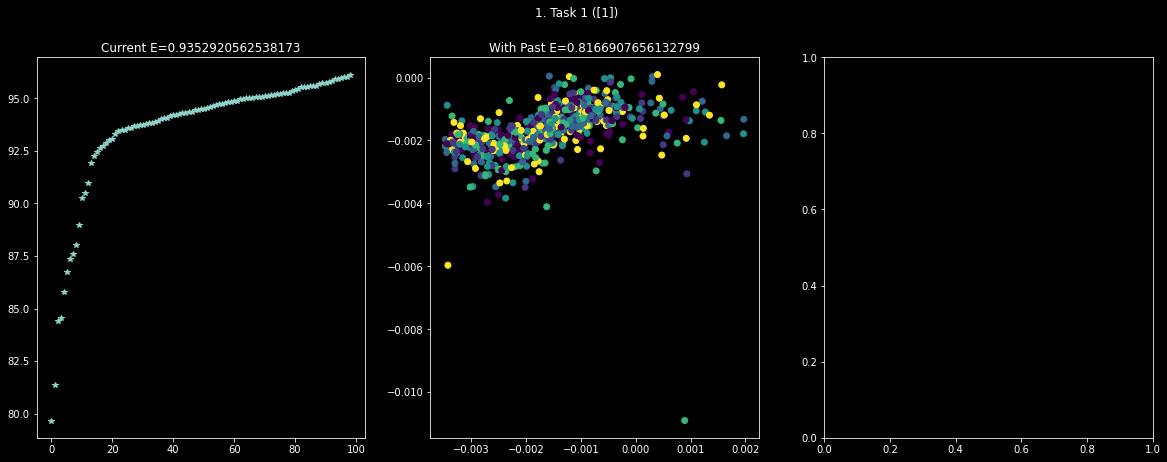

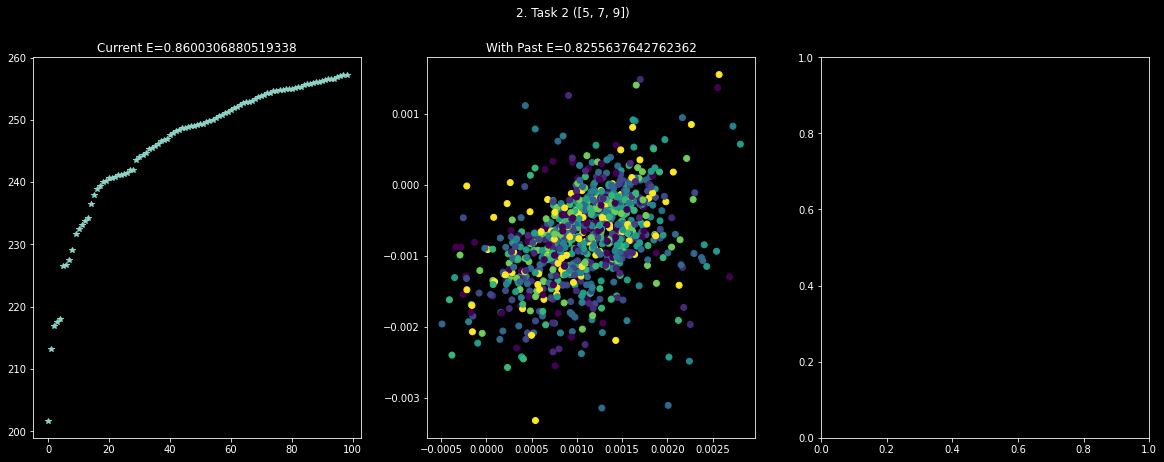

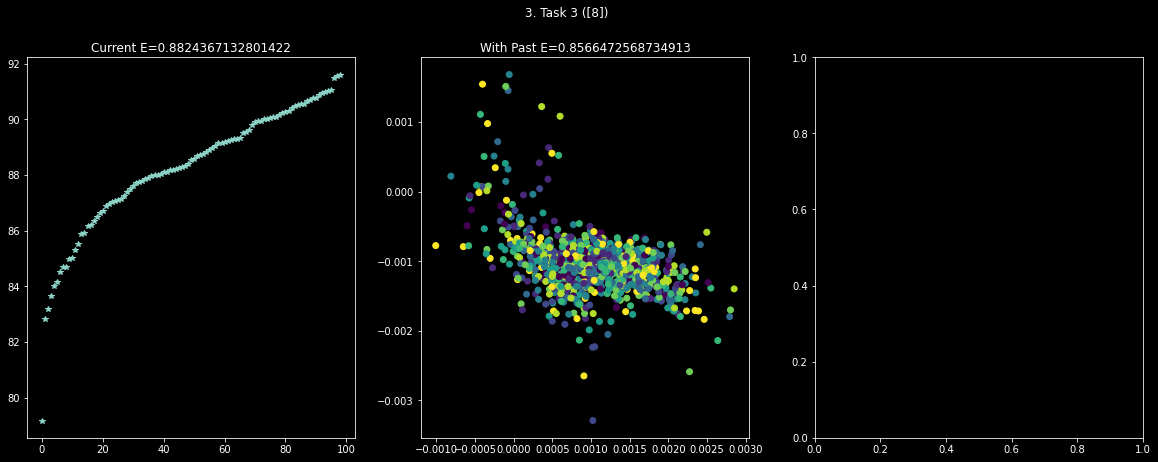

In [181]:
exp = exp_list[-1]
sigma = 1
print_exp_info(exp)
figsize = (20, 7)
limit = 100

for task_id in exp['results']:
    task_idx = int(task_id)
    task = exp['results'][task_id]
    targets = torch.tensor(task['targets'], device='cuda')
    latents = torch.tensor(task['latents'], device='cuda')
    knowledge = [k for k in exp['knowledge'].values()]
    for i in range(1, len(knowledge)):
        knowledge[i] = [k for k in knowledge[i] if k not in flatten_list(knowledge[:i])]

    cur_latents = latents[np.isin(targets.cpu(), knowledge[task_idx])]
    past_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]
    fut_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[task_idx:]))]
    past_targets = targets[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]

    fig, ax = plt.subplots(1, 3, figsize=figsize)
    A, D, L = calc_D_L_torch(cur_latents, sigma=sigma)
    eigenvalues, eigenvectors = find_eig_torch(L)
    # eigenvalues /= len(cur_latents)
    ax[0].plot(eigenvalues[1:limit].cpu(), '*')
    ax[0].set_title(f'Current E={calc_energy_from_values(eigenvalues)}')

    A, D, L = calc_D_L_torch(past_latents, sigma=sigma)
    print((D.sum(1)-1).mean().item(),(D.sum(1)-1).std().item(), (D.sum(1)-1).min().item(), (D.sum(1)-1).max().item())
    eigenvalues, eigenvectors, sorted_ind = find_eig_torch(L, return_sorted_indices=True)
    # eigenvalues /= len(past_latents)
    # ax[1].plot(eigenvalues[1:limit].cpu(), '*')
    sorted_past_targets = past_targets[sorted_ind]
    filt_1 = (np.quantile(eigenvectors[:, 1].cpu().numpy(), .99) > eigenvectors[:, 1].cpu().numpy()) & (eigenvectors[:, 1].cpu().numpy() > np.quantile(eigenvectors[:, 1].cpu().numpy(), .01))
    filt_2 = (np.quantile(eigenvectors[:, 2].cpu().numpy(), .99) > eigenvectors[:, 2].cpu().numpy()) & (eigenvectors[:, 1].cpu().numpy() > np.quantile(eigenvectors[:, 2].cpu().numpy(), .01))
    filt_total = filt_1 & filt_2
    ax[1].scatter(eigenvectors[filt_total, 1].cpu(), eigenvectors[filt_total, 2].cpu(), c=sorted_past_targets[filt_total].cpu())
    ax[1].set_title(f'With Past E={calc_energy_from_values(eigenvalues)}')

    # ts = TSNE(n_components=2, random_state=0, perplexity=30)
    # tr = ts.fit_transform(eigenvectors[:,:5].cpu().numpy())
    # ax[2].scatter(tr[:,0], tr[:,1], c=past_targets[sorted_ind].cpu())

    plt.suptitle(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})')
    # ts = TSNE(n_components=2, perplexity=30, random_state=0)
    # tr = ts.fit_transform(past_latents.cpu().numpy())
    # data = pd.DataFrame(np.concatenate([tr, past_targets.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
    # fig,ax = plt.subplots(figsize=(10,10))
    # sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax)

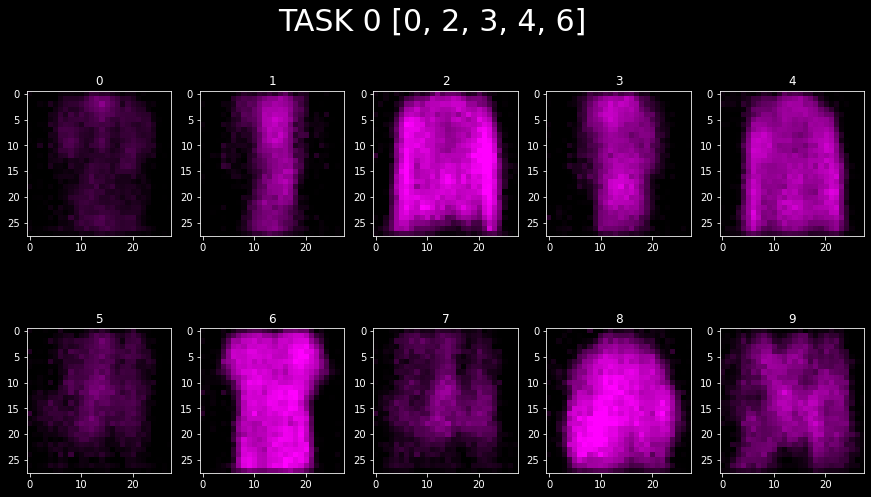

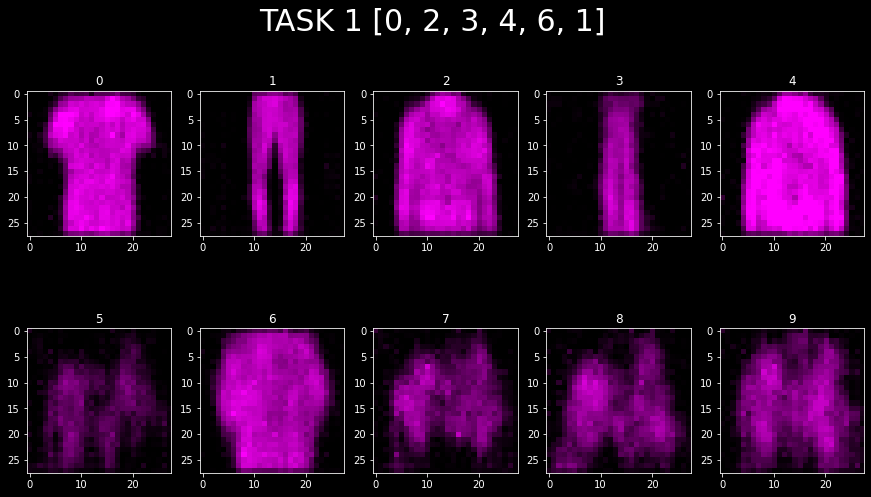

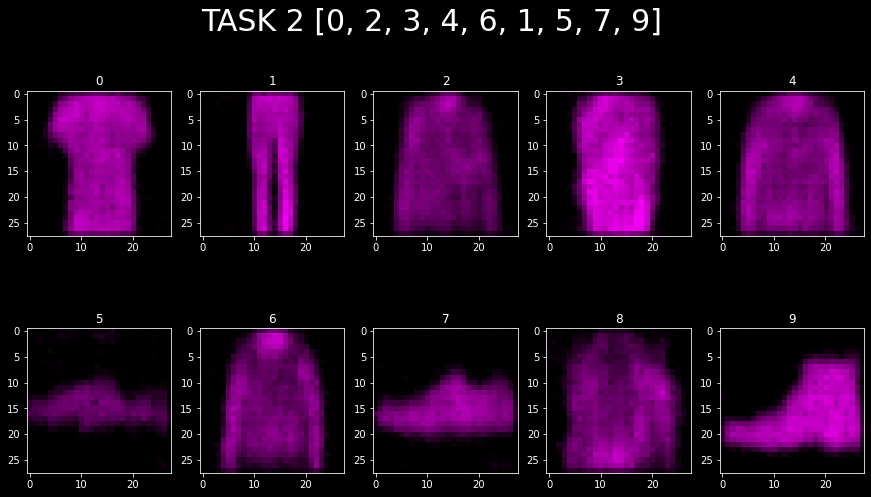

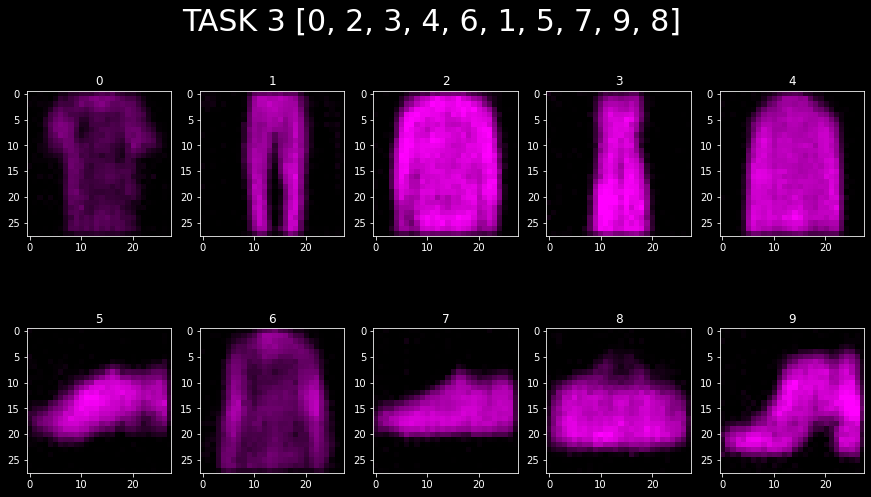

In [179]:
show_exp_images(exp)

In [48]:
useless_cols = ['seed', 'logs', 'timestamp']
# cols without duplicates
model_cols = {
    'common_pre': ['n_epochs', 'batch_size', 'optim', 'lr', 'model'],
    'ae': ['latent_space'],
    'dae': ['noise_mean', 'noise_std'],
    'sae': ['sparse_weight', 'norm_order'],
    'vae': ['kl_weight', 'beta_kl', 'forward_sample'],
    'common_post': ['approach', ['id']]
}
result_cols = ['results', 'knowledge']

group_cols = [col for cols in model_cols for col in model_cols[cols]]
order_cols = group_cols + result_cols

methods_list = []
def method_id(df: pd.DataFrame):
    idx = len(methods_list)
    methods_list.append({'exps': list(df)})
    return idx

for env in environments:
    env_cols = [prop for prop in env['env']]

    results = pd.DataFrame.from_records(env['exps'])
    tot_cols = results.columns.tolist()
    exclude_cols = [col for col in useless_cols + env_cols if col in tot_cols]
    orderby_cols = [col for col in order_cols if col in tot_cols]
    groupby_cols = [col for col in group_cols if col in tot_cols]
    unknown_cols = [col for col in tot_cols if col not in exclude_cols + orderby_cols]
    env['unknown'] = unknown_cols
    results = results[orderby_cols]
    results['runs'] = 1
    results = results.groupby(groupby_cols, dropna=False).agg(
        {'runs': 'count', 'id': method_id, **{res: ['mean', 'std'] for res in result_cols}}
    )
    for index, res in results.iterrows():
        id_met = int(res[('id', 'method_id')])
        methods_list[id_met]['props'] = {name: index[i] for i, name in enumerate(results.index.names)}
        methods_list[id_met]['env'] = env['env']
        methods_list[id_met]['results'] = {res_col: {'mean': res[(res_col, 'mean')], 'std': res[(res_col, 'std')]} for res_col in result_cols}

    env['results'] = results

sort = False
sort_col = ('auc_final', 'mean')
for env in environments:
    print('ENV INFO - ' + str(env['env']))
    if len(env['unknown']):
        print('-- unknown props: ' + str(env['unknown']))
    display(env['results'].sort_values(sort_col, ascending=False) if sort else env['results'])
    print('-'*100 + '\n')



KeyError: "Column(s) ['id'] do not exist"